# 📥 Step 0: Load Dataset


In [17]:

import pandas as pd

# Load the dataset
df = pd.read_csv("diabetes.csv")
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 📊 Step 1: Exploratory Data Analysis (EDA)


### ➤ Dataset Info and Summary


In [2]:
print("Data Types:\n", df.dtypes)
print("\nSummary Statistics:\n", df.describe())


Data Types:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Summary Statistics:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000 

### ➤ Check for Zero Values (treated as missing)


In [3]:
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("Zero counts in critical medical columns:\n", df[zero_cols].isin([0]).sum())


Zero counts in critical medical columns:
 Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


### ➤ Target Distribution


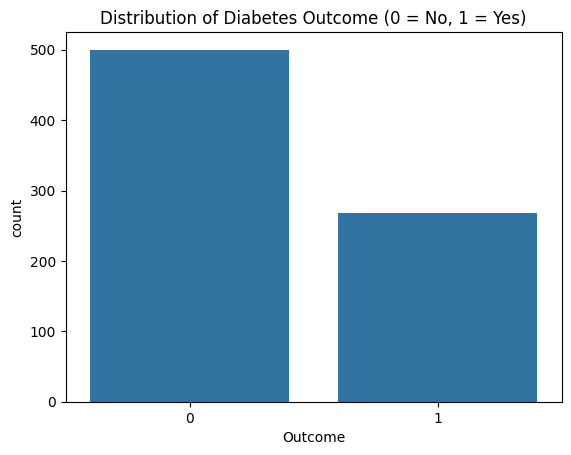

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Outcome', data=df)
plt.title("Distribution of Diabetes Outcome (0 = No, 1 = Yes)")
plt.show()


### ➤ Correlation Heatmap


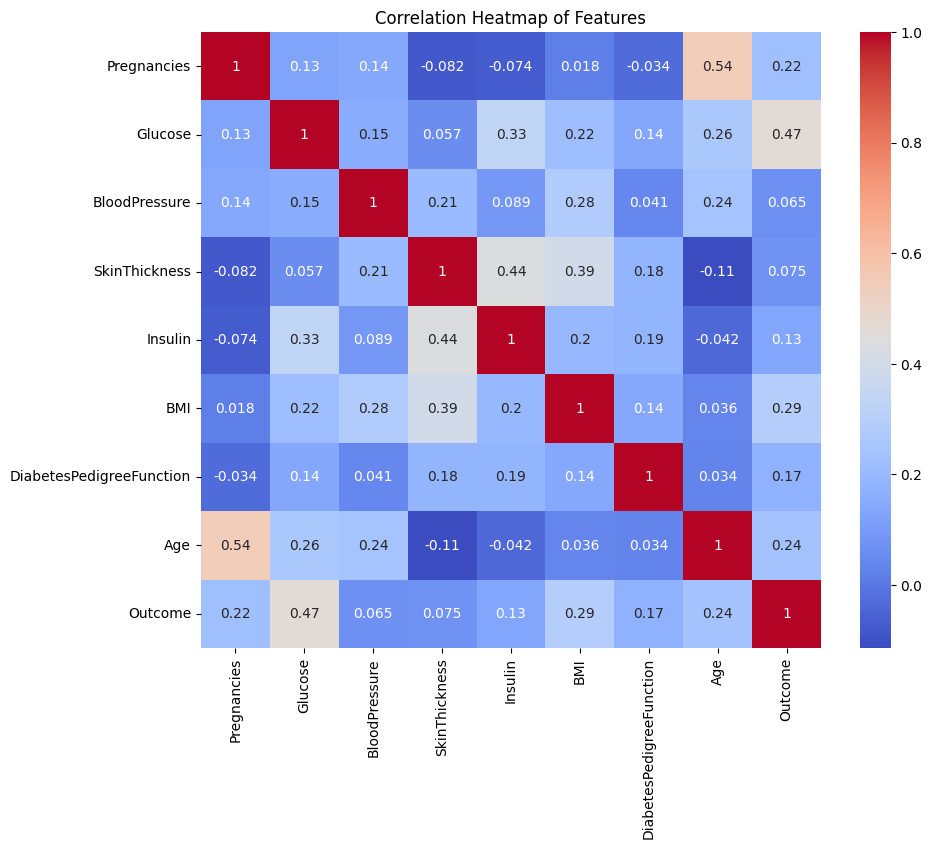

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()


# 🔧 Step 2: Preprocessing & Feature Selection


### ➤ Replace Zeros with NaN, Then Impute


In [6]:
df[zero_cols] = df[zero_cols].replace(0, pd.NA)
df.fillna(df.mean(), inplace=True)


C:\Users\Ch Hassan\AppData\Local\Temp\ipykernel_8500\2204686918.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(df.mean(), inplace=True)


### ➤ Split Features & Labels + Scale Features


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### ➤ Select Best Features


In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=8)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)


Selected Features: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


### ➤ Train-Test Split


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


# 🤖 Step 3: Model Training (GB, SVM, MLP)


### ➤ Train Gradient Boosting


In [10]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

### ➤ Train Support Vector Machine


In [11]:
from sklearn.svm import SVC

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)


SVC(probability=True, random_state=42)

### ➤ Train Neural Network (MLP)


In [12]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)


MLPClassifier(max_iter=1000, random_state=42)

# 📈 Step 4: Model Evaluation (F1 Score & AUC-ROC)


In [13]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

models = {
    "Gradient Boosting": gb_model,
    "SVM": svm_model,
    "Neural Network": mlp_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n🧪 {name} Evaluation:")
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC Score:", roc_auc_score(y_test, y_prob))



🧪 Gradient Boosting Evaluation:
F1 Score: 0.6551724137931034
AUC-ROC Score: 0.8168962350780532

🧪 SVM Evaluation:
F1 Score: 0.6274509803921569
AUC-ROC Score: 0.8102846648301193

🧪 Neural Network Evaluation:
F1 Score: 0.631578947368421
AUC-ROC Score: 0.7983471074380166


## ➤ Plot ROC Curves


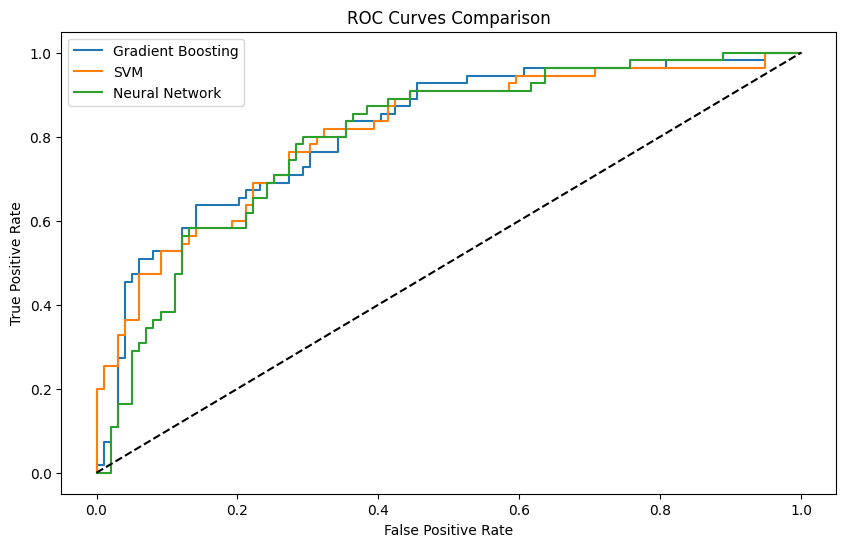

In [14]:
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()


# 🩺 Step 5: Insights for Healthcare Professionals


### ✅ Insights from Model Predictions

1. **High Blood Glucose & BMI Levels** are strongly predictive of diabetes.

   - 🔬 _Healthcare teams should focus on regular monitoring and management of these metrics._

2. **Low Insulin and High Age** also correlate with positive diabetes diagnosis.

   - 🧪 _Early testing and lifestyle changes can reduce risks in older individuals._

3. **Pregnancies and SkinThickness** provide additional predictive power.

   - 👩‍⚕️ _Pregnant individuals with abnormal metrics should receive extra screenings._

4. **Clinical Decision Support**:
   - Models like Gradient Boosting provide high AUC and F1, suggesting high reliability in detecting positive cases.
   - Best model from testing can be integrated into a hospital's decision support system.
